## POS tagging using modified Viterbi

## Data Preparation

In [1]:
#Importing libraries
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Check first 20 records
nltk_data[:20]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

### Split the dataset

In [4]:
print("Number of Sentences in Whole Dataset ", len(nltk_data))
train_set, test_set = train_test_split(nltk_data, test_size = 0.05,random_state = 0)
print("Number of Sentences in Training Dataset", len(train_set))
print("Number of Sentences in Validation Dataset", len(test_set))

Number of Sentences in Whole Dataset  3914
Number of Sentences in Training Dataset 3718
Number of Sentences in Validation Dataset 196


In [5]:
# check one record
train_set[1]

[('Under', 'ADP'),
 ('the', 'DET'),
 ('new', 'ADJ'),
 ('U.S.', 'NOUN'),
 ('trade', 'NOUN'),
 ('law', 'NOUN'),
 (',', '.'),
 ('those', 'DET'),
 ('countries', 'NOUN'),
 ('could', 'VERB'),
 ('face', 'VERB'),
 ('accelerated', 'ADJ'),
 ('unfair-trade', 'ADJ'),
 ('investigations', 'NOUN'),
 ('and', 'CONJ'),
 ('stiff', 'ADJ'),
 ('trade', 'NOUN'),
 ('sanctions', 'NOUN'),
 ('if', 'ADP'),
 ('they', 'PRON'),
 ('do', 'VERB'),
 ("n't", 'ADV'),
 ('improve', 'VERB'),
 ('their', 'PRON'),
 ('protection', 'NOUN'),
 ('of', 'ADP'),
 ('intellectual', 'ADJ'),
 ('property', 'NOUN'),
 ('by', 'ADP'),
 ('next', 'ADJ'),
 ('spring', 'NOUN'),
 ('.', '.')]

#### Convert sentences to list of words and tags

In [6]:
# prepare tagged word from train set
train_tagged_words = [word for sentence in train_set for word in sentence]
print("Total Words in train_set:",len(train_tagged_words))
train_tagged_words[:10]

Total Words in train_set: 95749


[('By', 'ADP'),
 ('comparison', 'NOUN'),
 (',', '.'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('first', 'ADJ'),
 ('nine', 'NUM'),
 ('months', 'NOUN'),
 (',', '.'),
 ('Xerox', 'NOUN')]

In [7]:
# Get the words in test Set 
test_tagged_words_base = [(word_tag[0],word_tag[1]) for sentence in test_set for word_tag in sentence]
test_words = [word_tag[0] for sentence in test_set for word_tag in sentence]
print("Total Words in test_set:",len(test_words))
test_tagged_words_base[:10]

Total Words in test_set: 4927


[('You', 'PRON'),
 ('do', 'VERB'),
 ("n't", 'ADV'),
 ('want', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('get', 'VERB'),
 ('yourself', 'PRON'),
 ('too', 'ADV'),
 ('upset', 'ADJ')]

## Exploratory Data Analysis

#### Unique Tags

In [8]:
# get list of all tags and store in a list
tags = [i[1] for i in train_tagged_words]
print("Number of unique tags", len(set(tags)))
set(tags)

Number of unique tags 12


{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [9]:
# Most frequent tags
tag_counts = Counter(tags)
tag_counts.most_common(5)

[('NOUN', 27487), ('VERB', 12882), ('.', 11141), ('ADP', 9365), ('DET', 8278)]

### Observation 
- We can Noun and Verb are the most common tags assigned to words
- There 12 different kinds of tags in the training dataset

### Tokens, vocabulary, number of tags

In [10]:
# Tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['By',
 'comparison',
 ',',
 'for',
 'the',
 'first',
 'nine',
 'months',
 ',',
 'Xerox']

In [11]:
# Vocabulary
V = set(tokens)
print("Length of vocabulary", len(V))

Length of vocabulary 12072


In [12]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print("number of tags",len(T))
print(T)

number of tags 12
{'NUM', 'ADP', 'VERB', 'PRT', 'CONJ', 'ADJ', 'PRON', '.', 'NOUN', 'ADV', 'DET', 'X'}


## Build the vanilla Viterbi based POS tagger
### Emission Probablities

#### computing Emission P(w/t) and storing in T x V matrix

In [13]:
t = len(T)
v = len(set(test_words))
# Frame T x V matrix and initialize with zero
w_given_t = np.zeros((v, t))
w_given_t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Define a function to compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    # print("Number of tags found for the given tag",tag,"is",count_tag)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    # print("Number of word found for the given word in the tag list",word,"is",count_w_given_tag)
    return (count_w_given_tag, count_tag)

In [15]:
# Prepare the Emission Matrix for all the test words as it will re used in different viterbi algorithm 
# and it will be faster to calculate to POS Tags and evaluate
for key, word in enumerate(set(test_words)):
    for tag_index,tag in enumerate(T):
        emission_tup = word_given_tag(word, tag)
        #print(word,key,tag_index)
        w_given_t[key,tag_index] = emission_tup[0]/emission_tup[1]
w_given_t

array([[0.        , 0.        , 0.00046577, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16920393],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00659631, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00031051, ..., 0.        , 0.        ,
        0.        ]])

In [16]:
# Lets create Dataframe out of the emission matrix
emission_df = pd.DataFrame(w_given_t,index=set(test_words),columns=T)
emission_df.head()

,NUM,ADP,VERB,PRT,CONJ,ADJ,PRON,.,NOUN,ADV,DET,X
issue,0.0,0.0,0.000466,0.0,0.000000,0.0,0.0,0.0,0.001855,0.0,0.0,0.000000
*-1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.169204
minus,0.0,0.0,0.000000,0.0,0.000465,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
lovely,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
assume,0.0,0.0,0.000155,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


### Transition Probabilities 

In [17]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
tags_matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [19]:
# for each comobination of tags, calculate tranisition probabilty and store it in matrix
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        # calculate transition prob for t2 given t1
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
tags_matrix

array([[1.86225250e-01, 3.34023051e-02, 1.86225250e-02, 2.68992018e-02,
        1.41885905e-02, 3.34023051e-02, 1.77357381e-03, 1.14395507e-01,
        3.52054387e-01, 2.95595615e-03, 3.25155188e-03, 2.12828845e-01],
       [6.27869740e-02, 1.70848910e-02, 8.22210312e-03, 1.38814736e-03,
        8.54244514e-04, 1.06994130e-01, 6.93005845e-02, 4.04698327e-02,
        3.21623057e-01, 1.32407900e-02, 3.23118001e-01, 3.49172466e-02],
       [2.25120317e-02, 9.22217071e-02, 1.68607354e-01, 3.15168463e-02,
        5.43393893e-03, 6.48967549e-02, 3.45443264e-02, 3.50100920e-02,
        1.10153705e-01, 8.22077319e-02, 1.34761676e-01, 2.18133837e-01],
       [5.62459119e-02, 2.12557223e-02, 4.01569664e-01, 1.96206663e-03,
        1.96206663e-03, 8.40418562e-02, 1.70045774e-02, 4.34924774e-02,
        2.48855457e-01, 9.81033314e-03, 1.00065403e-01, 1.37344673e-02],
       [3.90697680e-02, 5.30232564e-02, 1.57674417e-01, 4.65116277e-03,
        4.65116289e-04, 1.19069770e-01, 5.76744191e-02, 3.48

In [20]:
# convert the matrix to a df for better readability
# rows represent given tags, columns represent transition prob to from the given tag in row
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,NUM,ADP,VERB,PRT,CONJ,ADJ,PRON,.,NOUN,ADV,DET,X
NUM,0.186225,0.033402,0.018623,0.026899,0.014189,0.033402,0.001774,0.114396,0.352054,0.002956,0.003252,0.212829
ADP,0.062787,0.017085,0.008222,0.001388,0.000854,0.106994,0.069301,0.040470,0.321623,0.013241,0.323118,0.034917
VERB,0.022512,0.092222,0.168607,0.031517,0.005434,0.064897,0.034544,0.035010,0.110154,0.082208,0.134762,0.218134
PRT,0.056246,0.021256,0.401570,0.001962,0.001962,0.084042,0.017005,0.043492,0.248855,0.009810,0.100065,0.013734
CONJ,0.039070,0.053023,0.157674,0.004651,0.000465,0.119070,0.057674,0.034884,0.349302,0.056279,0.119535,0.008372
ADJ,0.021214,0.076961,0.011840,0.010853,0.016116,0.066765,0.000493,0.064134,0.701036,0.004933,0.004933,0.020720
PRON,0.007734,0.021655,0.489559,0.012374,0.005414,0.073473,0.006574,0.037896,0.208430,0.034416,0.010054,0.092421
.,0.081591,0.090207,0.088143,0.002334,0.057984,0.043982,0.066332,0.092900,0.222781,0.052958,0.172785,0.027915
NOUN,0.009459,0.176629,0.146324,0.043875,0.042456,0.011933,0.004657,0.240077,0.265798,0.016990,0.012952,0.028850
ADV,0.031992,0.116425,0.347296,0.013852,0.006926,0.129947,0.015172,0.135224,0.031992,0.079156,0.069261,0.022757


### Heat Map to Visualize Transition Probabilties 

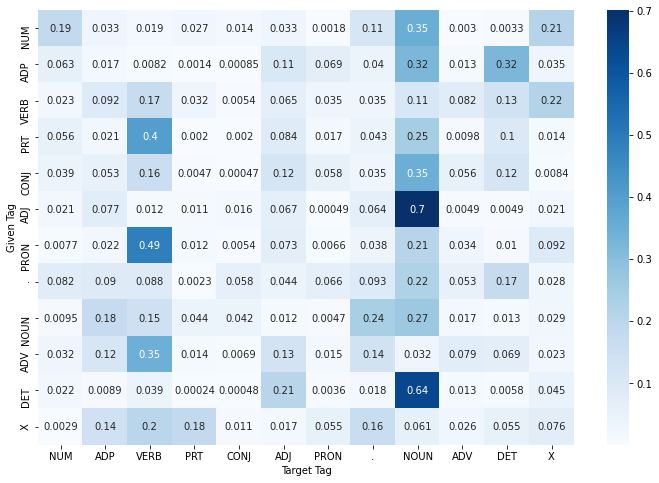

In [21]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=[12,8])
sns.heatmap(tags_df,cmap='Blues',annot=True)
plt.xlabel("Target Tag")
plt.ylabel("Given Tag")
plt.show()

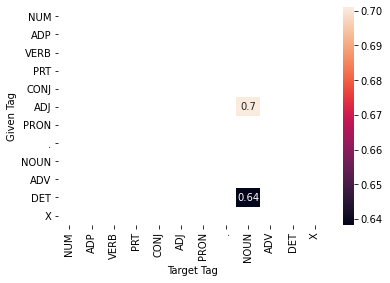

In [22]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
sns.heatmap(tags_frequent,annot=True)
plt.xlabel("Target Tag")
plt.ylabel("Given Tag")
plt.show()

### Observation:
- There is high probability that Noun will occur given previous tag of the word was Adjective or Determinant

### Build Viterbi Algorithm
Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [23]:
# Viterbi Heuristic
def ViterbiUnmodified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        prob_dict ={}
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_tup = word_given_tag(words[key], tag)
            emission_p = emission_tup[0]/emission_tup[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            prob_dict[tag]=state_probability
        #pmax = max(p)
        # getting state for which probability is maximum
        # state_max = T[p.index(pmax)] 
        state_max = max(prob_dict, key=prob_dict.get) 
        state.append(state_max)
    return list(zip(words, state))


### Testing with 5 Random Sentences

In [24]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]
test_run = [test_set[i] for i in rndom]
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
tagged_seq = ViterbiUnmodified(test_tagged_words)
tagged_seq

[('That', 'DET'),
 ('can', 'VERB'),
 ('be', 'VERB'),
 ('a', 'DET'),
 ('trap', 'NUM'),
 ('for', 'ADP'),
 ('unwary', 'NUM'),
 ('investors', 'NOUN'),
 (',', '.'),
 ('says', 'VERB'),
 ('0', 'X'),
 ('*T*-1', 'X'),
 ('Richard', 'NOUN'),
 ('Bernstein', 'NOUN'),
 (',', '.'),
 ('senior', 'ADJ'),
 ('quantitative', 'NUM'),
 ('analyst', 'NOUN'),
 ('at', 'ADP'),
 ('Merrill', 'NOUN'),
 ('Lynch', 'NOUN'),
 ('&', 'CONJ'),
 ('Co', 'NOUN'),
 ('.', '.'),
 ('Title', 'NOUN'),
 ('X', 'NOUN'),
 ('funds', 'NOUN'),
 ('are', 'VERB'),
 ('the', 'DET'),
 ('single', 'ADJ'),
 ('largest', 'ADJ'),
 ('source', 'NOUN'),
 ('of', 'ADP'),
 ('federal', 'ADJ'),
 ('funding', 'NOUN'),
 ('for', 'ADP'),
 ('family-planning', 'ADJ'),
 ('services', 'NOUN'),
 (',', '.'),
 ('according', 'VERB'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('opinion', 'NOUN'),
 ('by', 'ADP'),
 ('the', 'DET'),
 ('Second', 'ADJ'),
 ('U.S.', 'NOUN'),
 ('Circuit', 'NOUN'),
 ('Court', 'NOUN'),
 ('of', 'ADP'),
 ('Appeals', 'NUM'),
 ('in', 'ADP'),
 ('New', 'NOUN'),
 (

### Accuracy

In [25]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print("Accuracy",accuracy)

Accuracy 0.8865248226950354


### Observation 
- we see that testing with five random sentences, we get accuracy of 87% with Vanilla Viterbi

### Check incorrect tags

In [26]:
# Compare predicted tags with actual tags
for i,j in enumerate(zip(tagged_seq, test_run_base)):
    if j[0]!=j[1]:
        print(i,j)

4 (('trap', 'NUM'), ('trap', 'NOUN'))
6 (('unwary', 'NUM'), ('unwary', 'ADJ'))
16 (('quantitative', 'NUM'), ('quantitative', 'ADJ'))
45 (('Second', 'ADJ'), ('Second', 'NOUN'))
50 (('Appeals', 'NUM'), ('Appeals', 'NOUN'))
58 (('Tulane', 'NUM'), ('Tulane', 'NOUN'))
70 (('array', 'NUM'), ('array', 'NOUN'))
77 (('thread', 'NUM'), ('thread', 'NOUN'))
90 (('twinned', 'NUM'), ('twinned', 'VERB'))
98 (('complete', 'VERB'), ('complete', 'ADJ'))
102 (('upstream', 'NUM'), ('upstream', 'ADV'))
118 (('Goldsmith', 'NUM'), ('Goldsmith', 'NOUN'))
120 (('Hoylake', 'NUM'), ('Hoylake', 'NOUN'))
121 (('Investments', 'NUM'), ('Investments', 'NOUN'))
130 (('Hoylake', 'NUM'), ('Hoylake', 'NOUN'))
132 (('sweeten', 'NUM'), ('sweeten', 'VERB'))


In [27]:
# Lets check previous word-tag, predicted word-tag, actual word-tag,next word-tag
# i: index, j: tuple(prediction,actual)
incorrect_tagged_cases = [[test_run_base[i-1],j,test_run_base[i+1]] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
# Outputs list of [previous word-tag, predicted word-tag, actual word-tag] of incorrectly tagged words
print("[previous word-tag, predicted word-tag, actual word-tag,next word-tag]")
incorrect_tagged_cases

[previous word-tag, predicted word-tag, actual word-tag,next word-tag]


[[('a', 'DET'), (('trap', 'NUM'), ('trap', 'NOUN')), ('for', 'ADP')],
 [('for', 'ADP'),
  (('unwary', 'NUM'), ('unwary', 'ADJ')),
  ('investors', 'NOUN')],
 [('senior', 'ADJ'),
  (('quantitative', 'NUM'), ('quantitative', 'ADJ')),
  ('analyst', 'NOUN')],
 [('the', 'DET'), (('Second', 'ADJ'), ('Second', 'NOUN')), ('U.S.', 'NOUN')],
 [('of', 'ADP'), (('Appeals', 'NUM'), ('Appeals', 'NOUN')), ('in', 'ADP')],
 [('by', 'ADP'), (('Tulane', 'NUM'), ('Tulane', 'NOUN')), ('Prof.', 'NOUN')],
 [('complex', 'ADJ'), (('array', 'NUM'), ('array', 'NOUN')), ('of', 'ADP')],
 [('common', 'ADJ'), (('thread', 'NUM'), ('thread', 'NOUN')), ('of', 'ADP')],
 [('be', 'VERB'), (('twinned', 'NUM'), ('twinned', 'VERB')), ('*-3', 'X')],
 [('nearly', 'ADV'), (('complete', 'VERB'), ('complete', 'ADJ')), (',', '.')],
 [('miles', 'NOUN'),
  (('upstream', 'NUM'), ('upstream', 'ADV')),
  ('in', 'ADP')],
 [('James', 'NOUN'),
  (('Goldsmith', 'NUM'), ('Goldsmith', 'NOUN')),
  ("'s", 'PRT')],
 [("'s", 'PRT'),
  (('Hoylake'

### Check using Test Set

In [28]:
# Lets modify the Viterbi Heuristic function to use the emission matrix prepared for test set words as it will be faster
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        prob_dict ={}
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emission_df.loc[word, tag]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            prob_dict[tag]=state_probability
        # getting state for which probability is maximum
        state_max = max(prob_dict, key=prob_dict.get) 
        state.append(state_max)
    return list(zip(words, state))


In [29]:
# Apply Vanilla Viterbi on Test Set Words
tagged_seq_test = Viterbi(test_words)
tagged_seq_test[:10]

[('You', 'PRON'),
 ('do', 'VERB'),
 ("n't", 'ADV'),
 ('want', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT'),
 ('get', 'VERB'),
 ('yourself', 'PRON'),
 ('too', 'ADV'),
 ('upset', 'VERB')]

### Accuracy

In [30]:
# accuracy
check = [i for i, j in zip(tagged_seq_test, test_tagged_words_base) if i == j] 
accuracy_vanilla = round(len(check)/len(tagged_seq_test),3)
print("Accuracy of Vanilla Viterbi",accuracy_vanilla)

Accuracy of Vanilla Viterbi 0.91


### Observation
- We see that using plain Viterbi Algorithm, We are getting accuracy of 90% on test set

In [31]:
# Lets compare the tags for incorrectly tagged sequence
for i,j in enumerate(zip(tagged_seq_test, test_tagged_words_base)):
    if j[0]!=j[1]:
        print(i,j)

9 (('upset', 'VERB'), ('upset', 'ADJ'))
33 (('Tulane', 'NUM'), ('Tulane', 'NOUN'))
45 (('array', 'NUM'), ('array', 'NOUN'))
52 (('thread', 'NUM'), ('thread', 'NOUN'))
59 (('like', 'ADP'), ('like', 'VERB'))
75 (('statue', 'NUM'), ('statue', 'NOUN'))
78 (('Jefferson', 'NUM'), ('Jefferson', 'NOUN'))
79 (('dissolves', 'NUM'), ('dissolves', 'VERB'))
101 (('away', 'ADV'), ('away', 'PRT'))
126 (('eight-person', 'NUM'), ('eight-person', 'ADJ'))
176 (('away', 'ADV'), ('away', 'PRT'))
188 (('incest', 'NUM'), ('incest', 'NOUN'))
207 (('transforming', 'NUM'), ('transforming', 'VERB'))
231 (('chaotic', 'NUM'), ('chaotic', 'ADJ'))
259 (('mirror', 'VERB'), ('mirror', 'NOUN'))
263 (('fabled', 'NUM'), ('fabled', 'ADJ'))
264 (('virtues', 'NUM'), ('virtues', 'NOUN'))
277 (('Manchester', 'NUM'), ('Manchester', 'NOUN'))
279 (('N.H.', 'NUM'), ('N.H.', 'NOUN'))
281 (('values', 'NOUN'), ('values', 'VERB'))
295 (('untrained', 'NUM'), ('untrained', 'ADJ'))
300 (('botched', 'NUM'), ('botched', 'ADJ'))
309 (('dis

In [32]:
# i: index, j: tuple(prediction,actual)
incorrect_tagged_cases = [[test_tagged_words_base[i-1],j] for i, j in enumerate(zip(tagged_seq_test, test_tagged_words_base)) if j[0]!=j[1]]
# Outputs list of [previous word-tag, predicted word-tag, actual word-tag] of incorrectly tagged words
print("Number of incorrectly tagged sequence",len(incorrect_tagged_cases))
print("First 10 incorrectly tagged sequence")
print("[previous word-tag, predicted word-tag, actual word-tag]")
incorrect_tagged_cases[:10]

Number of incorrectly tagged sequence 441
First 10 incorrectly tagged sequence
[previous word-tag, predicted word-tag, actual word-tag]


[[('too', 'ADV'), (('upset', 'VERB'), ('upset', 'ADJ'))],
 [('by', 'ADP'), (('Tulane', 'NUM'), ('Tulane', 'NOUN'))],
 [('complex', 'ADJ'), (('array', 'NUM'), ('array', 'NOUN'))],
 [('common', 'ADJ'), (('thread', 'NUM'), ('thread', 'NOUN'))],
 [('would', 'VERB'), (('like', 'ADP'), ('like', 'VERB'))],
 [('the', 'DET'), (('statue', 'NUM'), ('statue', 'NOUN'))],
 [('Thomas', 'NOUN'), (('Jefferson', 'NUM'), ('Jefferson', 'NOUN'))],
 [('Jefferson', 'NOUN'), (('dissolves', 'NUM'), ('dissolves', 'VERB'))],
 [('take', 'VERB'), (('away', 'ADV'), ('away', 'PRT'))],
 [("'s", 'PRT'), (('eight-person', 'NUM'), ('eight-person', 'ADJ'))]]

In [33]:
# Lets convert to Dataframe
incorrect_tagged_cases_dict = [{'word': j[0][0],'predicted_tag':j[0][1],
                           'actual_tag':j[1][1],'previous_word':test_tagged_words_base[i-1][0],
                           'previous_word_actual_tag':test_tagged_words_base[i-1][1]} 
                               for i, j in enumerate(zip(tagged_seq_test, test_tagged_words_base)) if j[0]!=j[1]]
incorrect_tagged_df = pd.DataFrame(incorrect_tagged_cases_dict)
incorrect_tagged_df.head(10)

,word,predicted_tag,actual_tag,previous_word,previous_word_actual_tag
0,upset,VERB,ADJ,too,ADV
1,Tulane,NUM,NOUN,by,ADP
2,array,NUM,NOUN,complex,ADJ
3,thread,NUM,NOUN,common,ADJ
4,like,ADP,VERB,would,VERB
5,statue,NUM,NOUN,the,DET
6,Jefferson,NUM,NOUN,Thomas,NOUN
7,dissolves,NUM,VERB,Jefferson,NOUN
8,away,ADV,PRT,take,VERB
9,eight-person,NUM,ADJ,'s,PRT


In [34]:
# Lets find the Incorrectly tagged words and its vocabulary
incorrect_words = [group[1][0][0] for group in incorrect_tagged_cases]
incorrect_words_vocabulary = set(incorrect_words)
incorrect_words_vocabulary

{"'s",
 '*-103',
 '*-112',
 '*-130',
 '*T*-102',
 '*T*-155',
 '*T*-160',
 '*T*-198',
 '*T*-201',
 '*T*-207',
 '*T*-222',
 '*T*-237',
 '*T*-239',
 '*T*-24',
 '*T*-242',
 '120-a-share',
 '190-point',
 '21-month',
 '3',
 'A',
 'Anglia',
 'Appeals',
 'Ariail',
 'B-1B',
 'Billings',
 'British',
 'C-90',
 'CDs',
 'Calder',
 'Cataracts',
 'Communication',
 'Continuing',
 'Customers',
 'DeFazio',
 'Delmont',
 'Democracy',
 'Deregulation',
 'DiLoreto',
 'Dill',
 'Dolphins',
 'Dutch',
 'East',
 'Elsevier',
 'Fargo',
 'Farren',
 'Filmed',
 'GHKM',
 'GOODY',
 'Gilts',
 'Goldsmith',
 'Great',
 'Griffin',
 'Helsinki',
 'History',
 'Hoylake',
 'Integra-A',
 'Internatonal',
 'Investments',
 'Jefferson',
 'Jonas',
 'Judah',
 'L.P.',
 'Lilly',
 'Lorenzo',
 'MEDICINE',
 'Manchester',
 'Matthews',
 'Mindy',
 'Mogavero',
 'More',
 'Moreover',
 'Mortgage-Backed',
 'N.H.',
 'Named',
 'Net',
 'New',
 'Nigel',
 'Noriega',
 'PRODUCTS',
 'Patricia',
 'Pattenden',
 'Periods',
 'Piscataway',
 'Ranger',
 'Restauran

In [35]:
# Get number of unique words in the incorrect tagged words
len(incorrect_words_vocabulary)

400

### Emission probabilty of incorrectly tagged words

In [36]:
# Lets check the emmision probabilty of incorrectly tagged nouns as they are more
for i,row in incorrect_tagged_df.head(20).iterrows():
    emi_prob = word_given_tag(row['word'],row['actual_tag'])
    print("Emission Probabilty of",row['word'],'with tag',row['actual_tag'],'is:',emi_prob[0]/emi_prob[1])
    

Emission Probabilty of upset with tag ADJ is: 0.0
Emission Probabilty of Tulane with tag NOUN is: 0.0
Emission Probabilty of array with tag NOUN is: 0.0
Emission Probabilty of thread with tag NOUN is: 0.0
Emission Probabilty of like with tag VERB is: 0.0008539046731873933
Emission Probabilty of statue with tag NOUN is: 0.0
Emission Probabilty of Jefferson with tag NOUN is: 0.0
Emission Probabilty of dissolves with tag VERB is: 0.0
Emission Probabilty of away with tag PRT is: 0.0006540222367560497
Emission Probabilty of eight-person with tag ADJ is: 0.0
Emission Probabilty of away with tag PRT is: 0.0006540222367560497
Emission Probabilty of incest with tag NOUN is: 0.0
Emission Probabilty of transforming with tag VERB is: 0.0
Emission Probabilty of chaotic with tag ADJ is: 0.0
Emission Probabilty of mirror with tag NOUN is: 0.0
Emission Probabilty of fabled with tag ADJ is: 0.0
Emission Probabilty of virtues with tag NOUN is: 0.0
Emission Probabilty of Manchester with tag NOUN is: 0.0


### Observation
- We can see that for many incorrectly tagged words, the emission probability is zero
- The reason why emission probability is zero is because the words are not present in training dataset
- Since the emission probability is zero, the tag is choosen random as there is no maximum state probability and all of them is zero

In [37]:
# Lets experiment initializing zeros in list and get index for maximum
p = [0,0,0,0,0]
p.index(max(p))

0

## Analyze the results from Vanilla Viterbi Algorithm

In [38]:
# Find the most incorrectly taggged tag
incorrect_tagged_df['actual_tag'].value_counts()

NOUN    191
VERB     95
ADJ      95
ADV      24
X        15
DET       8
PRT       8
ADP       3
CONJ      1
NUM       1
Name: actual_tag, dtype: int64

### Observation 
- We see that most number of Nouns are incorrectly tagged
- We can assign the most occurring tag NOUN for the unknown words to boost the accuracy, but its wrong as others will also be incorrectly tagged as NOUN. 

In [39]:
# Find the most predicted tag for Noun
incorrect_tagged_df[incorrect_tagged_df.actual_tag=='NOUN']['predicted_tag'].value_counts()

NUM     161
ADJ      16
VERB     12
DET       1
CONJ      1
Name: predicted_tag, dtype: int64

### Observation
- We see that most of nouns are incorrectly tagged as Determinant

In [40]:
# Find the tag of preceeding word of noun
incorrect_tagged_df[(incorrect_tagged_df.actual_tag=='NOUN') ]['previous_word_actual_tag'].value_counts()

NOUN    44
DET     39
ADJ     31
.       22
ADP     16
VERB    10
CONJ    10
PRON     6
PRT      6
X        5
NUM      2
Name: previous_word_actual_tag, dtype: int64

### Observation 
- We see that Most of incorrectly tagged nouns are after either a noun, determinant or adjective

## Find Unknown Words

In [41]:
# lets find the unknown words which are not present in Training Dataset Vocabulary
unknown_words = [word for word in test_words if word not in V]
print("Number of unknown words present in test set but not in train set",len(unknown_words),"\n")
print(unknown_words)

Number of unknown words present in test set but not in train set 342 

['4.75', 'Tulane', 'array', 'thread', 'statue', 'Jefferson', 'dissolves', 'eight-person', 'incest', 'transforming', 'chaotic', 'fabled', 'virtues', 'Manchester', 'N.H.', 'untrained', 'botched', 'disarray', 'downgraded', 'buck', 'prior-year', 'adjustment', 'bomber', 'sewing-machine', '185.9', 'inspection', '77,000', 'glamorize', 'vagabond', 'existence', 'Nigel', 'Judah', 'ends', 'whimsical', 'enviable', 'fights', 'two-time-losers', 'Lorenzo', 'twinned', 'upstream', 'Periods', 'advent', 'undergoing', '1973-75', '1937-40', '1928-33', 'corn-buying', 'binge', 'bottlenecks', 'pipeline', 'doubts', 'sticker-shock', 'talked', 'excited', 'astronomical', 'collection', 'Appeals', 'schemes', 'pharaohs', 'erect', 'playgrounds', 'passions', 'arbitrager', 'sad', 'performers', 'grapple', '420', 'fair', 'Lilly', 'Mindy', '*T*-24', 'C-90', 'Third', '11.57', '*T*-102', 'Communication', 'plane', 'mid-1990s', 'Helsinki', '16.9', '17.4', 

In [42]:
# Lets find how many incorrectly tagged words are unknown words
len([i for i in incorrect_words_vocabulary if i in set(unknown_words)]) / len(unknown_words)

0.8596491228070176

### Observation 
- We can see that close to 98% incorrectly tagged words are unknown words

## Solve the problem of unknown words

### Modify Viterbi Algorithm to handle unknown words
Since the emission probability is zero for unknown words, Hence lets consider transition probability for unknown words

In [43]:
# Viterbi Heuristic
def ViterbiModified_laplace(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        prob_dict ={}
        prob_dict_transition ={}
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities
            emission_p = emission_df.loc[word,tag]
            state_probability = (emission_p+0.0001) * transition_p  
            p.append(state_probability)
            prob_dict[tag]=state_probability
        
        state_max = max(prob_dict, key=prob_dict.get) 
        state.append(state_max)
    return list(zip(words, state))
# Lets apply viterbi modified algorithm on test set
tagged_seq_test_laplace = ViterbiModified_laplace(test_words)
# accuracy
check = [i for i, j in zip(tagged_seq_test_laplace, test_tagged_words_base) if i == j] 
accuracy_modified_laplace = round(len(check)/len(tagged_seq_test_laplace),3)
print("Accuracy",accuracy_modified_laplace)

Accuracy 0.909


### Observation
- With laplace smoothing, we get the same accuracy, hence its not helping much

# Viterbi Modification-Technique I

In [44]:
# Viterbi Heuristic without laplace smoothing
def ViterbiModified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        prob_dict ={}
        prob_dict_transition ={}
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            # Check if word is present in Training dataset
            if word in V:
                # compute emission and state probabilities
                emission_p = emission_df.loc[word,tag]
                state_probability = emission_p * transition_p  
            else:
                state_probability = transition_p
            p.append(state_probability)
            prob_dict[tag]=state_probability
        
        state_max = max(prob_dict, key=prob_dict.get) 
        state.append(state_max)
    return list(zip(words, state))


In [45]:
# Lets apply viterbi modified algorithm on test set
tagged_seq_test_m = ViterbiModified(test_words)

In [46]:
# accuracy
check = [i for i, j in zip(tagged_seq_test_m, test_tagged_words_base) if i == j] 
accuracy_modified = round(len(check)/len(tagged_seq_test_m),3)
print("Accuracy",accuracy_modified)

Accuracy 0.931


### Observation 
- After modifying the viterbi without laplace smoothing, accuracy increased to 93%

### Lexicon Unigram Tagger
Lets check if Unigram Tagger of nltk library is able to improve the accuracy

In [47]:
# Train Unigram Tagger
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram = round(unigram_tagger.evaluate(test_set),3)
# Evaluate on Test Set
print("Accuracy",accuracy_unigram)

Accuracy 0.902


### Observation
- We see using Unigram Tagger, the accuracy didn't improve much 
- Hence lets apply regex Parser to check if accuracy improves. But before we apply regex parser lets analyze the results of plain Viterbi Algorithm which will help in framing regex parser

### Regex Parser/ Rule Based Tagger
different rules were experimented, to tag the words and appropriate rules were choosen. But these are all commented as the length of notebook will increase. 

In [48]:
#incorrect_tagged_df[incorrect_tagged_df.word.str.contains(r'[A-Za-z]+[-|.]*\d+')][['word','actual_tag']].head(20)
#incorrect_tagged_df[incorrect_tagged_df.word.str.contains(r'[A-Za-z]+[-|.]*\d+')]['actual_tag'].value_counts()
#incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'\*T\*-\d')][['word','actual_tag']].head(20)
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'.*s$')][['word','actual_tag']]['actual_tag'].value_counts()
#incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'.*ing$|.*ed$|.*es$')][['word','actual_tag']]['actual_tag'].value_counts()
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'.*ould$')][['word','actual_tag']].head(20)
#incorrect_tagged_df[incorrect_tagged_df.actual_tag=='NOUN'].head(20)
#incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'.*\'s$')][['word','actual_tag']].head(20)
#incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'^-?[0-9]+(.[0-9]+)?$')][['word','actual_tag']].head(20)
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'.*ly')][['word','actual_tag']].head(20)
#incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'^(0|([*|-|$].*))')][['word','actual_tag']].head(50)
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'(The|the|A|a|An|an)$')][['word','actual_tag']].head(50)
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'(\w)+\-\w*$')][['word','actual_tag']].head(50)
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'(\w)+\-\w*$')]['actual_tag'].value_counts()
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$')]['actual_tag'].value_counts()
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'.*')][['word','actual_tag']]
# incorrect_tagged_df[incorrect_tagged_df.word.str.match(r'^(\d|[a-zA-Z])+\-[a-zA-Z]*$')][['word','actual_tag']]

In [49]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'\*T\*-\d','X'), # cardinal numbers
    (r'^(0|([*|-|$].*))','X'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),
    (r'^[A-Za-z]+[-|.]*\d+','NOUN'),
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^(\d|[a-zA-Z])+\-[a-zA-Z]*$','ADJ'),
    (r'.*ly$', 'ADV'),                # Adverb
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN')                    # nouns
]

In [50]:
# Initialize the regular expression tagger
regexp_tagger = nltk.RegexpTagger(patterns)
# Evaluate the tagger
accuracy_rulebased = regexp_tagger.evaluate(test_set)
print("Accuracy of simple Rule Based Approach",accuracy_rulebased)

Accuracy of simple Rule Based Approach 0.46925106555713414


### Combining Regex Tagger with Unigram Tagger

In [51]:
# Train a unigram tagger with rule based tagger as backup for unknown words
unigram_tagger_rule_based = nltk.UnigramTagger(train_set,backoff=regexp_tagger)
# Evaluate the unigram tagger
accuracy_unigram_rulebased = round(unigram_tagger_rule_based.evaluate(test_set),3)
print("Accuracy of Unigram Rule Based Approach",accuracy_unigram_rulebased)

Accuracy of Unigram Rule Based Approach 0.955


### Observation
- We can see using unigram tagger along with rule based tagger, the accuracy increased to 95%

### Combining Unigram Regex Tagger with Bigram Tagger

In [52]:
# Train a bigram tagger with previous unigram based tagger as backup for unknown words
bigram_tagger_rule_based = nltk.BigramTagger(train_set,backoff=unigram_tagger_rule_based)
# Evaluate the bigram tagger
accuracy_bigram_rulebased = round(bigram_tagger_rule_based.evaluate(test_set),3)
print("Accuracy of Bigram Rule Based Approach",accuracy_bigram_rulebased)

Accuracy of Bigram Rule Based Approach 0.958


### Observation
- We see that using Bigram Tagger along with rule based method as backoff, the accuracy increased by small amount of 0.03% to close to 96%. 

### Combining Bigram Regex Tagger with Trigram Tagger

In [53]:
# Train a trigram tagger with previous bigram based tagger as backup for unknown words
trigram_tagger_rule_based = nltk.TrigramTagger(train_set,backoff=bigram_tagger_rule_based)
# Evaluate the trigram tagger
accuracy_trigram_rulebased = round(trigram_tagger_rule_based.evaluate(test_set),3)
print("Accuracy of Trigram Rule Based Approach",accuracy_trigram_rulebased)

Accuracy of Trigram Rule Based Approach 0.958


### Observation 
- We see that accuracy almost remained the same which is close to 96%

# Viterbi Modification-Technique II

### Modifying Viterbi with Trigram
Lets use trigram tagger created above for unknown words along with modified vanilla viterbi for known words

In [54]:
# Viterbi Heuristic
def ViterbiTrigram(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # Check if word is present in Training dataset
        if word in V:
            #initialise list of probability column for a given observation
            p = [] 
            prob_dict ={}
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = emission_df.loc[word,tag]
                state_probability = emission_p * transition_p  
                p.append(state_probability)
                prob_dict[tag]=state_probability

            state_max = max(prob_dict, key=prob_dict.get) 
            state.append(state_max)
            
        # Lets use trigram tagger for word not in training dataset
        else:
            state.append(trigram_tagger_rule_based.tag([word])[0][1])
    return list(zip(words, state))


In [55]:
# Check the Viterbi trigram with test set
tagged_seq_test_trigram = ViterbiTrigram(test_words)

In [56]:
# accuracy
check_trigram = [i for i, j in zip(tagged_seq_test_trigram, test_tagged_words_base) if i == j] 
accuracy_trigram_probablistic = round(len(check_trigram)/len(tagged_seq_test_trigram),3)
print("Accuracy of Trigram Rule Based Approach along with probalistic",accuracy_trigram_probablistic)

Accuracy of Trigram Rule Based Approach along with probalistic 0.955


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [57]:
# Prepare a Dataframe containing accuracy of different methods to compare with vanilla accuracy
accuracy_final = {"accuracy_probablistic_vanilla":accuracy_vanilla,
                  "accuracy_unigram":accuracy_unigram,
                  "accuracy_rulebased":round(accuracy_rulebased,3),
                  "accuracy_unigram_rulebased":accuracy_unigram_rulebased,
                  "accuracy_bigram_rulebased":accuracy_bigram_rulebased,
                  "accuracy_trigram_rulebased":accuracy_trigram_rulebased,
                  "accuracy_probablistic_modified":accuracy_modified,
                  "accuracy_probablistic_trigram":accuracy_trigram_probablistic}
accuracy_final_df = pd.DataFrame(accuracy_final.values(),index=accuracy_final.keys(),columns=['Accuracy Scores'])
accuracy_final_df

,Accuracy Scores
accuracy_probablistic_vanilla,0.910
accuracy_unigram,0.902
accuracy_rulebased,0.469
accuracy_unigram_rulebased,0.955
accuracy_bigram_rulebased,0.958
accuracy_trigram_rulebased,0.958
accuracy_probablistic_modified,0.931
accuracy_probablistic_trigram,0.955


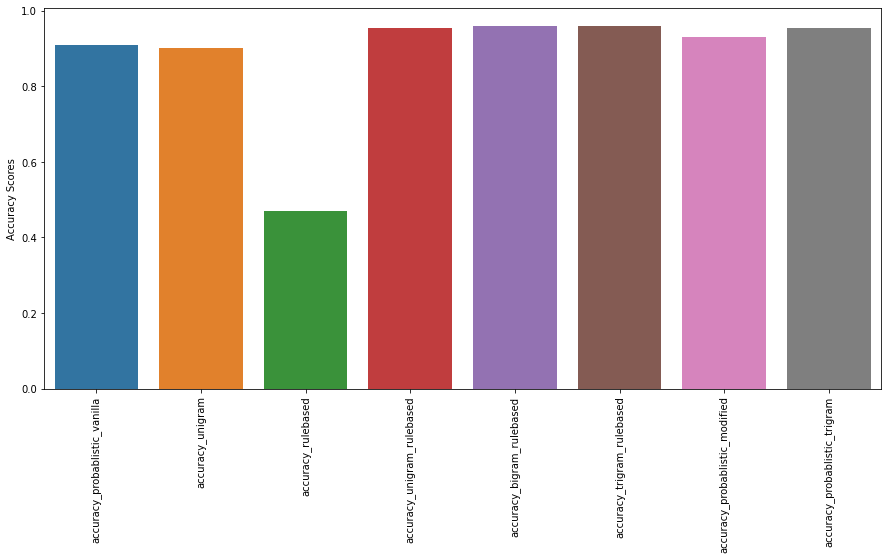

In [58]:
# Plot a barplot to compare the accuracy
plt.figure(figsize=[15,7])
sns.barplot(x=accuracy_final_df.index,y=accuracy_final_df['Accuracy Scores'])
plt.xticks(rotation=90)
plt.show()

### Observation 
- We see that by modifying the vanilla probabilistic approach to consider the transition probability instead of emission increase the accuracy 
- The Highest accuracy is attained by lexical tagger was trigram tagger along with rule based approach. 
- Among the Probabilistic models, the combination of trigram for unknown words and modified viterbi for known words has got the highest accuracy which is also very close to lexical-rulebased trigram tagger . 
- Hence the combination of Viterbi for known words along with rules based trigram model for unknown words is better choice for pos tagging

## Final two Modifications
Lets create generic function which does not use emission probability matrix of test set and calculates emission probability 

### Viterbi Modification-Technique I

In [59]:
# Viterbi Generic Heuristic without laplace smoothing, this does not use emission probabilty matrix prepared for test set
def ViterbiModifiedGeneric(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        prob_dict ={}
        prob_dict_transition ={}
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            # Check if word is present in Training dataset
            if word in V:
                # compute emission and state probabilities
                emission_tup = word_given_tag(word,tag)
                emission_p = emission_tup[0]/emission_tup[1]
                state_probability = emission_p * transition_p  
            else:
                state_probability = transition_p
            p.append(state_probability)
            prob_dict[tag]=state_probability
        
        state_max = max(prob_dict, key=prob_dict.get) 
        state.append(state_max)
    return list(zip(words, state))


### Viterbi Modification-Technique II

In [60]:
''' Lets modify the Probablistic viterbi trigram function to handle any test sentence passed on to it. 
 Previously we re used the emission matrix for test set, hence it needs to be modified to consider any 
 test sentences passed on to it '''
# Viterbi Heuristic
def ViterbiTrigramGeneric(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # Check if word is present in Training dataset
        if word in V:
            #initialise list of probability column for a given observation
            p = [] 
            prob_dict ={}
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_tup = word_given_tag(word,tag)
                emission_p = emission_tup[0]/emission_tup[1]
                state_probability = emission_p * transition_p  
                p.append(state_probability)
                prob_dict[tag]=state_probability

            state_max = max(prob_dict, key=prob_dict.get) 
            state.append(state_max)
            
        # Lets use trigram tagger for word not in training dataset
        else:
            state.append(trigram_tagger_rule_based.tag([word])[0][1])
    return list(zip(words, state))


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [61]:
# Lets check pos tags predicted by vanilla pos tagger for unknown words 
incorrect_tagged_df[incorrect_tagged_df['word'].isin(unknown_words[:10])][['word','predicted_tag','actual_tag']]

,word,predicted_tag,actual_tag
1,Tulane,NUM,NOUN
2,array,NUM,NOUN
3,thread,NUM,NOUN
5,statue,NUM,NOUN
6,Jefferson,NUM,NOUN
7,dissolves,NUM,VERB
9,eight-person,NUM,ADJ
11,incest,NUM,NOUN
12,transforming,NUM,VERB


In [62]:
# Lets apply the Final Viterbi Heuristics(Technique II) on the above incorrectly tagged words 
ViterbiTrigramGeneric(unknown_words[:10])

[('4.75', 'NUM'),
 ('Tulane', 'NOUN'),
 ('array', 'NOUN'),
 ('thread', 'NOUN'),
 ('statue', 'NOUN'),
 ('Jefferson', 'NOUN'),
 ('dissolves', 'VERB'),
 ('eight-person', 'ADJ'),
 ('incest', 'NOUN'),
 ('transforming', 'VERB')]

### Observation 
- We can see that the words which were incorrectly tagged such as numbers like 4.75, Nouns like Tulane,Jefferson  adjectives like eight-person, and verb like transforming are correctly tagged after modifying the viterbi algorithm now

# Evaluating on Test Sentences 

In [63]:
# Read the test sentences text file
fp = open('Test_sentences.txt','r')
test_sentences_txt = fp.read()
fp.close()
test_sentences_txt

"Android is a mobile operating system developed by Google.\nAndroid has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\nGoogle and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\nTwitter is an online news and social networking service on which users post and interact with messages known as tweets.\nBefore entering politics, Donald Trump was a domineering businessman and a television personality.\nThe 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\nThis is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\nShow me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.\nShow me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\nNASA invited social media users to experience the launch of ICESAT-2 Satell

In [64]:
# remove extra newline characters
import re
test_sentences = re.sub(r'(\n\n)+', '', test_sentences_txt).split('\n')
test_sentences

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

## Evaluating Test Sentences using Vanilla Viterbi 

In [65]:
# Iterate through all sentences and apply modified viterbi on all tokenised words of sentences
vanilla_tagged_test = []
for i,sent in enumerate(test_sentences):
    print("Test Sentence",i+1)
    test_tokens = word_tokenize(sent)
    tagged_test_seq = ViterbiUnmodified(test_tokens)
    vanilla_tagged_test.append(tagged_test_seq)
    print(tagged_test_seq)
    print("-------"*20)
    print("\n\n")

Test Sentence 1
[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.')]
--------------------------------------------------------------------------------------------------------------------------------------------



Test Sentence 2
[('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
--------------------------------------------------------------------------------------------------------------------------------------------



Test Sentence 3
[('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), 

## Evaluating Test Sentences using Technique I

In [66]:
# Iterate through all sentences and apply modified viterbi on all tokenised words of sentences
tech1_tagged_test = []
for i,sent in enumerate(test_sentences):
    print("Test Sentence",i+1)
    test_tokens = word_tokenize(sent)
    tagged_test_seq = ViterbiModifiedGeneric(test_tokens)
    tech1_tagged_test.append(tagged_test_seq)
    print(tagged_test_seq)
    print("-------"*20)
    print("\n\n")

Test Sentence 1
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
--------------------------------------------------------------------------------------------------------------------------------------------



Test Sentence 2
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]
--------------------------------------------------------------------------------------------------------------------------------------------



Test Sentence 3
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VE

## Evaluating Test Sentences using Technique II

In [67]:
# Iterate through all sentences and apply modified viterbi on all tokenised words of sentences
tech2_tagged_test = []
for i,sent in enumerate(test_sentences):
    print("Test Sentence",i+1)
    test_tokens = word_tokenize(sent)
    tagged_test_seq = ViterbiTrigramGeneric(test_tokens)
    tech2_tagged_test.append(tagged_test_seq)
    print(tagged_test_seq)
    print("-------"*20)
    print("\n\n")

Test Sentence 1
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
--------------------------------------------------------------------------------------------------------------------------------------------



Test Sentence 2
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
--------------------------------------------------------------------------------------------------------------------------------------------



Test Sentence 3
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', '

In [68]:
# get list of all words
test_sent_words = [tup[0] for sent in tech2_tagged_test for tup in sent]
test_sent_tags_v = [tup[1] for sent in vanilla_tagged_test for tup in sent]
test_sent_tags_1 = [tup[1] for sent in tech1_tagged_test for tup in sent]
test_sent_tags_2 = [tup[1] for sent in tech2_tagged_test for tup in sent]
df_test_sent = pd.DataFrame({'words':test_sent_words,
                            'vanilla_viterbi':test_sent_tags_v,
                            'viterbi_modification1':test_sent_tags_1,
                            'viterbi_modification2':test_sent_tags_2})
# Compare which are tagged incorrectly and rectified by modifications
df_test_sent[(df_test_sent.vanilla_viterbi!=df_test_sent.viterbi_modification1) | (df_test_sent.vanilla_viterbi!=df_test_sent.viterbi_modification2)]

,words,vanilla_viterbi,viterbi_modification1,viterbi_modification2
0,Android,NUM,NOUN,NOUN
8,Google,NUM,DET,NOUN
10,Android,NUM,NOUN,NOUN
15,OS,NUM,NOUN,NOUN
16,worldwide,NUM,NOUN,NOUN
18,smartphones,NUM,DET,VERB
20,2011,NUM,DET,NUM
25,2013,NUM,DET,NUM
27,Google,NUM,NOUN,NOUN
29,Twitter,NUM,NOUN,NOUN


In [69]:
# Get unknown words
test_unknown = [w for sent in test_sentences for w in word_tokenize(sent) if w not in V]
len(test_unknown)/len([w for sent in test_sentences for w in word_tokenize(sent)])

0.19889502762430938

In [70]:
test_unknown[:10]

['Android',
 'Google',
 'Android',
 'OS',
 'worldwide',
 'smartphones',
 '2011',
 '2013',
 'Google',
 'Twitter']

### Observation
- We see that 19% of the words are unknown words which are not present in training dataset. 
- with just seeing the tagged words in the test sentences, we can see that few words like Android,Google,Twitter are correctly tagged as NOUN and 2011, 2013 as NUM. Hence we can say our modified Version of Viterbi has performed good